# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os #for import
import random
import matplotlib.pyplot as plt # data ploting
import cv2 #processing images

importing image labels and paths

In [2]:
path = '/kaggle/input/agricultural-crops-image-classification/Agricultural-crops'
classes = sorted(os.listdir(path), key=lambda s: s.lower()) #import class folders and sort ingoring case
image_paths = [] #store paths
labels = [] #store labels

for c in classes:
    class_folder = path + "/" + c #for each class define path
    for image in os.listdir(class_folder): 
        image_path = class_folder + "/" + image #for each image add to dataframe by path and label, i.e class
        image_paths.append(image_path)
        labels.append(c)

class_labels = np.unique(labels) #class labels
num_classes = len(class_labels)
# map labels to numerical values
label_mapping = {label: i for i, label in enumerate(class_labels)}
print(label_mapping)
labels = np.array([label_mapping[label] for label in labels]) #change from string to index from mapping
image_paths = np.array(image_paths) #convert to numpy array
df = pd.DataFrame({"image_paths":image_paths,"labels":labels}) #create dataframe
image_paths = df['image_paths']

{'Cherry': 0, 'Coffee-plant': 1, 'Cucumber': 2, 'Fox_nut(Makhana)': 3, 'Lemon': 4, 'Olive-tree': 5, 'Pearl_millet(bajra)': 6, 'Tobacco-plant': 7, 'almond': 8, 'banana': 9, 'cardamom': 10, 'chilli': 11, 'clove': 12, 'coconut': 13, 'cotton': 14, 'gram': 15, 'jowar': 16, 'jute': 17, 'maize': 18, 'mustard-oil': 19, 'papaya': 20, 'pineapple': 21, 'rice': 22, 'soyabean': 23, 'sugarcane': 24, 'sunflower': 25, 'tea': 26, 'tomato': 27, 'vigna-radiati(Mung)': 28, 'wheat': 29}


Dataframe:

In [3]:
df.head()

,image_paths,labels
0,/kaggle/input/agricultural-crops-image-classif...,8
1,/kaggle/input/agricultural-crops-image-classif...,8
2,/kaggle/input/agricultural-crops-image-classif...,8
3,/kaggle/input/agricultural-crops-image-classif...,8
4,/kaggle/input/agricultural-crops-image-classif...,8


# Image Data Generation
This function will help to convert images into datasets

it also handles normaliztion

In [4]:
def preprocess_image(image_path, target_size=(224, 224), normalize=True, show=False):
    try:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        # Resize the image to the target size
        image = cv2.resize(image, target_size)
        if normalize:
            # Convert pixel values to the range [0, 1]
            image = image.astype(np.float32) / 255.0
        if show:
            plt.imshow(image)
            plt.axis('off')  # Turn off axis labels and ticks
            plt.show()
        return image
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        return None

parameters for function

In [5]:
image_size = 128 # size of transofrmed image
normalize = True
show = False

In [6]:
images=[] #store processed images
for image_path in image_paths:
    image=preprocess_image(image_path, (image_size, image_size), normalize, show)
    images.append(image)
images = np.array(images) #convert to numpy array

flatten images:

In [7]:
images = images.reshape(images.shape[0], image_size * image_size * 3) #flatten images

Get number of samples in datasets, and number of pixels per picture

In [8]:
num_samples, num_pixels = images.shape

# Dividing data into test, train and validation
- 10% test set
- 90% trian and validation

In [9]:
def train_test_split(images, labels, test_size=0.1, num_rep=1, rand=True, strat=True):
    num_samples, _ = images.shape
    num_test = int(test_size * num_samples)
    indices = list(range(num_samples)) #indices of each image

    class_indices = [np.where(labels == c)[0] for c in range(num_classes)]
    # will return arrays of indices corrisponding to it's unique class
    
    # Initialize test_indices and train_indices lists
    test_indices = []
    train_indices = []
    
    # for function with number of repeitions to randomize our training and test sets
    for _ in range(num_rep):
        if strat:
            if rand:
                # permutates indices in each class(subarray)
                class_indices = [np.random.permutation(class_ids) for class_ids in class_indices]
            
            # Calculate the number of samples from each class for testing
            num_samples_per_class_test = [int(len(class_ids) * test_size) for class_ids in class_indices]

            for i, class_ids in enumerate(class_indices):
                test_indices.extend(class_ids[:num_samples_per_class_test[i]])
                train_indices.extend(class_ids[num_samples_per_class_test[i]:])
            
            # Shuffle the test and train indices if rand is True
            if rand:
                random.shuffle(test_indices)
                random.shuffle(train_indices)
        else:
            if rand:
                # Shuffle the indices randomly
                indices = np.random.permutation(num_samples)
            # Split the indices into training and testing sets
            
            test_indices = indices[:num_test]
            train_indices = indices[num_test:]
            
        if not rand: 
            break

    # Create the training and testing sets
    Xtr, Ytr = images[train_indices], labels[train_indices]
    Xte, Yte = images[test_indices], labels[test_indices]

    return Xtr, Xte, Ytr, Yte

In [10]:
Xtr, Xte, Ytr, Yte = train_test_split(images, labels, 0.1) # (10%) x (image_size * image_size * 3)

In [11]:
Xtr.shape

(757, 49152)

# 5 Fold Cross Validation

instead of creating new datasets, I will work with indices

Also, I will implement randomization so that each time I repeat cross validation, the data shuffles

In [12]:
num_folds = 5
num_rep = 1
rand = True
strat = True #stratification

stratification - the arrangement or classification of something into different groups.

In [13]:
def generate_cross_validation_pairs(X, y, num_folds=5, num_rep = 1, rand = True, strat = True):
    pairs = [] #store validation and train folds
    indices = list(range(len(y))) #indices of each image

    class_indices = [np.where(y == c)[0] for c in range(len(np.unique(y)))] 
    # will return arrays of indices corrisponding to it's unique class
    # for function with number of repeitions to randomize out folds
    for _ in range(num_rep):
        if strat:
            if rand:
                # permutates indices in each class(subarray)
                class_indices = [np.random.permutation(class_ids) for class_ids in class_indices]
            folds = [] #store divided indices for each fold
            #splites each class into num_folds arrays
            class_indices_split = [np.array_split(c, num_folds) for c in class_indices]

            for classes in zip(*class_indices_split):
                folds.append(np.concatenate(classes))
        else:
            if rand:
                #permutates indices
                random.shuffle(indices)
            #splits array into folds
            folds = np.array_split(indices, num_folds)

        for fold_idx in range(num_folds):
            val_fold = folds[fold_idx]
            train_folds = np.concatenate(np.delete(folds, fold_idx, axis=0))
            pairs.append([train_folds, val_fold])

        if not rand: 
            break
    return pairs;

In [14]:
pairs = generate_cross_validation_pairs(Xtr, Ytr)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [15]:
pairs[0][1] #validation set for first fold

array([410, 445,  54, 455, 308,  35, 478,  18,  23, 485, 619, 724, 663,
       698, 340, 477, 632, 211, 265, 486, 380, 303, 135, 723, 337, 390,
       461,  24, 353, 154, 614,  46, 755, 700, 413, 173, 329, 543, 164,
        64,  91, 618, 754, 317, 686, 183, 496, 503, 546, 438, 716, 620,
       125, 288, 379,   0, 318, 244, 604, 314, 697, 425, 607, 745, 426,
       419, 240, 223, 169,  11, 713, 680, 199, 274, 722, 144, 524,  16,
       706, 687, 206, 460, 230, 176, 667, 644, 248, 249, 682, 159, 242,
       517,  93, 572, 677, 167, 487, 339, 531, 103, 245, 161, 219, 208,
       260, 357, 205,  79, 298, 514, 407, 522, 226, 255, 397, 218, 148,
       575, 573, 129, 695, 377, 201, 225, 622,  97,  15, 446, 371, 469,
       437, 466, 180, 210, 490, 277, 448, 150,   1,  50, 290, 282, 539,
       549, 411, 550, 356, 699, 704, 436, 286, 259, 257,  87, 612, 534,
        86, 703, 247, 104, 457, 111, 693, 113, 220, 628])

Check for errors

In [16]:
print(image_paths[pairs[2][0][0]])
print(list(label_mapping.keys())[list(label_mapping.values()).index(labels[pairs[2][0][0]])])

/kaggle/input/agricultural-crops-image-classification/Agricultural-crops/maize/image (7).jpg
maize


# Algorithms

In [17]:
# Define regularization strength and learning rate
reg_strength = 0.01
learning_rate = 0.1

# Define the function to evaluate accuracy
def evaluate_accuracy(X, y, W):
    scores = np.dot(X, W)
    predicted_classes = np.argmax(scores, axis=1)
    accuracy = np.mean(predicted_classes == y)
    return accuracy

# Split the data into train, validation, and test sets using 5-fold cross-validation
def split_data(images, labels, pairs, fold):
    train_indices, val_indices = pairs[fold]
    X_train, y_train = images[train_indices], labels[train_indices]
    X_val, y_val = images[val_indices], labels[val_indices]
    return X_train, y_train, X_val, y_val

In [21]:
# Define the Softmax function
def softmax(scores):
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Define the cross-entropy loss function with regularization
def softmax_compute_loss(X, y, W, reg_strength):
    num_samples = X.shape[0]
    scores = np.dot(X, W)
    probs = softmax(scores)
    epsilon = 1e-8  # Small constant to prevent division by zero
    loss = -np.log(probs[range(num_samples), y] + epsilon)
    data_loss = np.sum(loss) / num_samples
    reg_loss = 0.5 * reg_strength * np.sum(W * W)
    total_loss = data_loss + reg_loss
    return total_loss

# Define the function to compute gradients of the loss function
def softmax_compute_gradient(X, y, W, reg_strength):
    num_samples = X.shape[0]
    scores = np.dot(X, W)
    probs = softmax(scores)
    probs[range(num_samples), y] -= 1
    probs /= num_samples
    gradient = np.dot(X.T, probs)
    gradient += reg_strength * W
    return gradient

# Define the gradient descent optimization for Softmax
def softmax_gradient_descent(X, y, W, learning_rate, reg_strength, num_epochs, batch_size):
    num_samples = X.shape[0]
    loss_history = []

    for epoch in range(num_epochs):
        for i in range(0, num_samples, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            gradient = softmax_compute_gradient(X_batch, y_batch, W, reg_strength)
            W -= learning_rate * gradient

        loss = softmax_compute_loss(X, y, W, reg_strength)
        loss_history.append(loss)
        print(f'Softmax - Epoch {epoch + 1}/{num_epochs}, Loss: {loss}')
        
    # Plot the training loss over epochs
    plt.plot(loss_history)
    plt.title('Softmax Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return W, loss_history

In [22]:
# Define the SVM loss function with regularization
def svm_compute_loss(X, y, W, reg_strength):
    num_samples = X.shape[0]
    scores = np.dot(X, W)
    correct_scores = scores[range(num_samples), y]
    margins = scores - correct_scores[:, np.newaxis] + 1
    margins[range(num_samples), y] = 0
    margins = np.maximum(0, margins)

    loss = np.sum(margins) / num_samples
    reg_loss = 0.5 * reg_strength * np.sum(W * W)
    total_loss = loss + reg_loss
    return total_loss

# Define the SVM gradient computation with regularization
def svm_compute_gradient(X, y, W, reg_strength):
    num_samples = X.shape[0]
    scores = np.dot(X, W)
    correct_scores = scores[range(num_samples), y]
    margins = scores - correct_scores[:, np.newaxis] + 1
    margins[range(num_samples), y] = 0
    margins = (margins > 0).astype(float)
    row_sum = np.sum(margins, axis=1)
    margins[range(num_samples), y] -= row_sum
    gradient = np.dot(X.T, margins)
    gradient /= num_samples
    gradient += reg_strength * W
    return gradient

# Define the gradient descent optimization for SVM
def svm_gradient_descent(X, y, W, learning_rate, reg_strength, num_epochs, batch_size):
    num_samples = X.shape[0]
    loss_history = []

    for epoch in range(num_epochs):
        for i in range(0, num_samples, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            gradient = svm_compute_gradient(X_batch, y_batch, W, reg_strength)
            W -= learning_rate * gradient

        loss = svm_compute_loss(X, y, W, reg_strength)
        loss_history.append(loss)
        print(f'SVM - Epoch {epoch + 1}/{num_epochs}, Loss: {loss}')

    # Plot the training loss over epochs
    plt.plot(loss_history)
    plt.title('Svm Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return W, loss_history

Fold 1/5
Training Softmax Regression...
Softmax - Epoch 1/200, Loss: 6624.060538094556
Softmax - Epoch 2/200, Loss: 6376.871710959131
Softmax - Epoch 3/200, Loss: 6139.240525881658
Softmax - Epoch 4/200, Loss: 5909.271482429648
Softmax - Epoch 5/200, Loss: 5690.1919480183205
Softmax - Epoch 6/200, Loss: 5477.819624212417
Softmax - Epoch 7/200, Loss: 5272.794940614069
Softmax - Epoch 8/200, Loss: 5076.168215440852
Softmax - Epoch 9/200, Loss: 4887.906430090389
Softmax - Epoch 10/200, Loss: 4706.025614596176
Softmax - Epoch 11/200, Loss: 4530.070234614993
Softmax - Epoch 12/200, Loss: 4361.346993501946
Softmax - Epoch 13/200, Loss: 4199.324997923008
Softmax - Epoch 14/200, Loss: 4043.2186212125
Softmax - Epoch 15/200, Loss: 3891.3166386891257
Softmax - Epoch 16/200, Loss: 3747.3775762408704
Softmax - Epoch 17/200, Loss: 3607.242104261416
Softmax - Epoch 18/200, Loss: 3475.166867953487
Softmax - Epoch 19/200, Loss: 3342.9894186286238
Softmax - Epoch 20/200, Loss: 3218.1391918076197
Softma

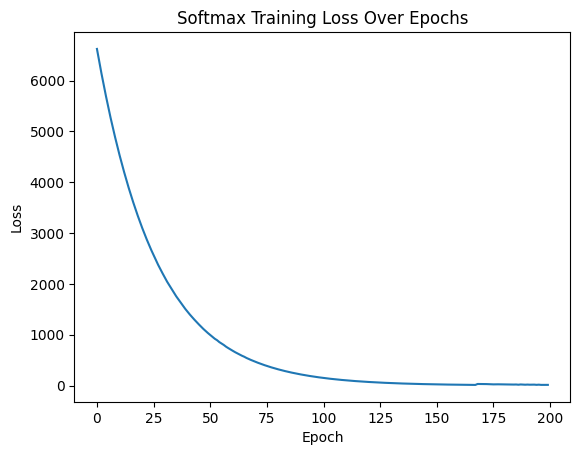

Training SVM...
SVM - Epoch 1/200, Loss: 14852.876137491505
SVM - Epoch 2/200, Loss: 8905.488304466675
SVM - Epoch 3/200, Loss: 7462.651774552541
SVM - Epoch 4/200, Loss: 6385.708359374075
SVM - Epoch 5/200, Loss: 6074.767227164141
SVM - Epoch 6/200, Loss: 5745.963688125425
SVM - Epoch 7/200, Loss: 5427.294246687608
SVM - Epoch 8/200, Loss: 5198.373935317801
SVM - Epoch 9/200, Loss: 5008.445812109999
SVM - Epoch 10/200, Loss: 4808.744498430033
SVM - Epoch 11/200, Loss: 4620.557852361177
SVM - Epoch 12/200, Loss: 4445.530026114416
SVM - Epoch 13/200, Loss: 4279.092699848913
SVM - Epoch 14/200, Loss: 4119.4636068038
SVM - Epoch 15/200, Loss: 3966.619753056025
SVM - Epoch 16/200, Loss: 3820.834790117078
SVM - Epoch 17/200, Loss: 3677.2831109597687
SVM - Epoch 18/200, Loss: 3538.5377804836207
SVM - Epoch 19/200, Loss: 3404.8372482525056
SVM - Epoch 20/200, Loss: 3278.68845125877
SVM - Epoch 21/200, Loss: 3156.657452554794
SVM - Epoch 22/200, Loss: 3039.4164644774537
SVM - Epoch 23/200, Los

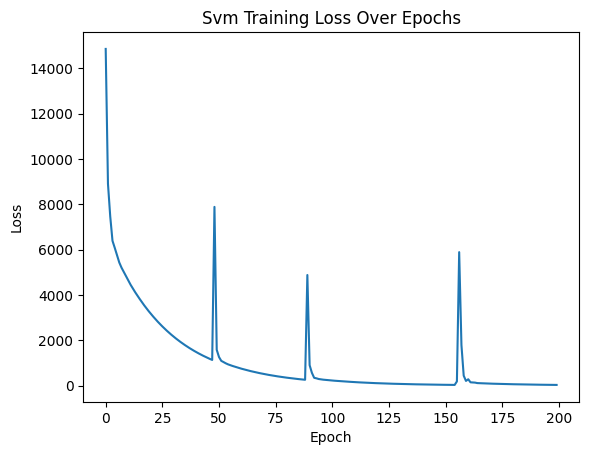

Softmax Regression Accuracy (Fold 1): 0.13855421686746988
SVM Accuracy (Fold 1): 0.1686746987951807
Fold 2/5
Training Softmax Regression...
Softmax - Epoch 1/200, Loss: 6635.973366535578
Softmax - Epoch 2/200, Loss: 6387.458770888514
Softmax - Epoch 3/200, Loss: 6149.677380572108
Softmax - Epoch 4/200, Loss: 5919.901049797484
Softmax - Epoch 5/200, Loss: 5699.054269296058
Softmax - Epoch 6/200, Loss: 5485.542344067875
Softmax - Epoch 7/200, Loss: 5281.4888204476465
Softmax - Epoch 8/200, Loss: 5086.119237480864
Softmax - Epoch 9/200, Loss: 4894.862043485323
Softmax - Epoch 10/200, Loss: 4714.092581551985
Softmax - Epoch 11/200, Loss: 4537.668828714674
Softmax - Epoch 12/200, Loss: 4370.311400290396
Softmax - Epoch 13/200, Loss: 4205.297739150124
Softmax - Epoch 14/200, Loss: 4049.5687523440097
Softmax - Epoch 15/200, Loss: 3899.961068891027
Softmax - Epoch 16/200, Loss: 3752.2679780127723
Softmax - Epoch 17/200, Loss: 3614.743503050564
Softmax - Epoch 18/200, Loss: 3476.1781430575556
S

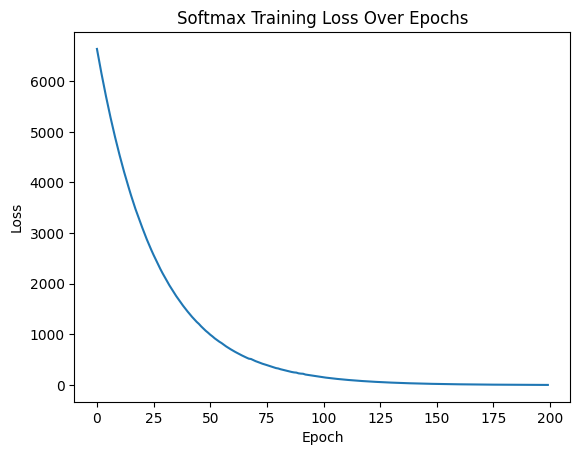

Training SVM...
SVM - Epoch 1/200, Loss: 10976.93669526093
SVM - Epoch 2/200, Loss: 7947.06227383744
SVM - Epoch 3/200, Loss: 7135.080277767673
SVM - Epoch 4/200, Loss: 6654.490143797255
SVM - Epoch 5/200, Loss: 6040.271360103569
SVM - Epoch 6/200, Loss: 5772.643984476808
SVM - Epoch 7/200, Loss: 5544.263376758806
SVM - Epoch 8/200, Loss: 5224.185695928126
SVM - Epoch 9/200, Loss: 5016.612650669977
SVM - Epoch 10/200, Loss: 4821.280919873068
SVM - Epoch 11/200, Loss: 4648.380239135705
SVM - Epoch 12/200, Loss: 4456.379068780964
SVM - Epoch 13/200, Loss: 4288.764170873123
SVM - Epoch 14/200, Loss: 4125.687254237571
SVM - Epoch 15/200, Loss: 3976.568124160445
SVM - Epoch 16/200, Loss: 3822.2688803812634
SVM - Epoch 17/200, Loss: 3678.8432918248063
SVM - Epoch 18/200, Loss: 3540.9410662208525
SVM - Epoch 19/200, Loss: 3409.7677580295294
SVM - Epoch 20/200, Loss: 3282.5924386639804
SVM - Epoch 21/200, Loss: 3160.925913340558
SVM - Epoch 22/200, Loss: 3042.723234133593
SVM - Epoch 23/200, L

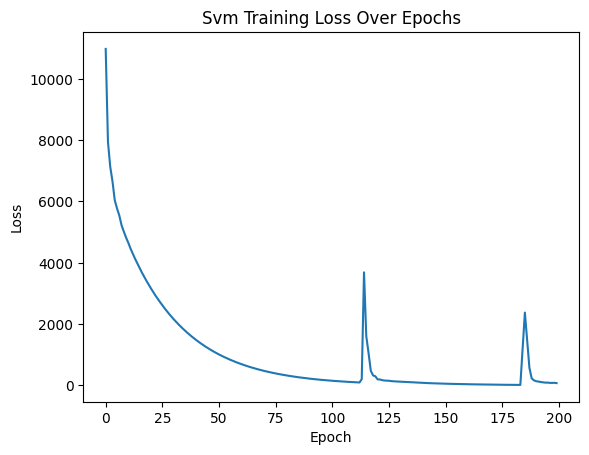

Softmax Regression Accuracy (Fold 2): 0.2088607594936709
SVM Accuracy (Fold 2): 0.20253164556962025
Fold 3/5
Training Softmax Regression...
Softmax - Epoch 1/200, Loss: 6637.9901100261395
Softmax - Epoch 2/200, Loss: 6390.012613905122
Softmax - Epoch 3/200, Loss: 6151.174226795762
Softmax - Epoch 4/200, Loss: 5922.013518770419
Softmax - Epoch 5/200, Loss: 5700.230722547472
Softmax - Epoch 6/200, Loss: 5488.798038795555
Softmax - Epoch 7/200, Loss: 5283.25796742703
Softmax - Epoch 8/200, Loss: 5085.639212863014
Softmax - Epoch 9/200, Loss: 4897.386737381549
Softmax - Epoch 10/200, Loss: 4715.535093416261
Softmax - Epoch 11/200, Loss: 4540.1629553960565
Softmax - Epoch 12/200, Loss: 4370.9994320766455
Softmax - Epoch 13/200, Loss: 4207.59973511155
Softmax - Epoch 14/200, Loss: 4053.0142962842656
Softmax - Epoch 15/200, Loss: 3900.441100443007
Softmax - Epoch 16/200, Loss: 3756.608343845223
Softmax - Epoch 17/200, Loss: 3616.2294371166445
Softmax - Epoch 18/200, Loss: 3481.0320318933263
S

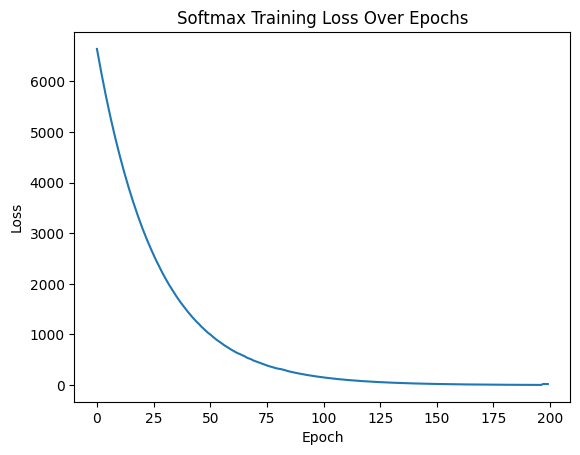

Training SVM...
SVM - Epoch 1/200, Loss: 11125.69671759344
SVM - Epoch 2/200, Loss: 8881.985840377207
SVM - Epoch 3/200, Loss: 7939.163288671297
SVM - Epoch 4/200, Loss: 6711.756774847344
SVM - Epoch 5/200, Loss: 5994.614098790462
SVM - Epoch 6/200, Loss: 5716.656434025455
SVM - Epoch 7/200, Loss: 5463.2922054067385
SVM - Epoch 8/200, Loss: 5235.979251905355
SVM - Epoch 9/200, Loss: 5026.894442445156
SVM - Epoch 10/200, Loss: 4823.44342606059
SVM - Epoch 11/200, Loss: 4636.904392198136
SVM - Epoch 12/200, Loss: 4462.878768628309
SVM - Epoch 13/200, Loss: 4296.337682967438
SVM - Epoch 14/200, Loss: 4135.839432436016
SVM - Epoch 15/200, Loss: 3978.390033728703
SVM - Epoch 16/200, Loss: 3829.2658741174923
SVM - Epoch 17/200, Loss: 3686.300204260691
SVM - Epoch 18/200, Loss: 3548.8494578773907
SVM - Epoch 19/200, Loss: 3448.007155495385
SVM - Epoch 20/200, Loss: 3289.313100895228
SVM - Epoch 21/200, Loss: 3165.5764606678063
SVM - Epoch 22/200, Loss: 3051.3368893859897
SVM - Epoch 23/200, L

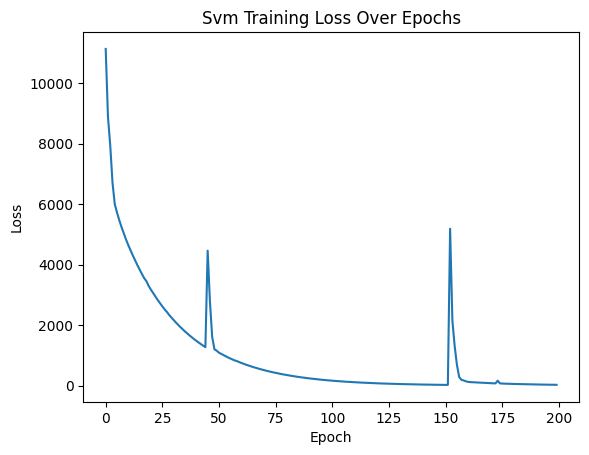

Softmax Regression Accuracy (Fold 3): 0.019867549668874173
SVM Accuracy (Fold 3): 0.24503311258278146
Fold 4/5
Training Softmax Regression...
Softmax - Epoch 1/200, Loss: 6639.35574786987
Softmax - Epoch 2/200, Loss: 6378.8041821111565
Softmax - Epoch 3/200, Loss: 6128.4925811639805
Softmax - Epoch 4/200, Loss: 5886.2674414341445
Softmax - Epoch 5/200, Loss: 5656.539182348689
Softmax - Epoch 6/200, Loss: 5434.436879619504
Softmax - Epoch 7/200, Loss: 5224.209122506819
Softmax - Epoch 8/200, Loss: 5016.820645029244
Softmax - Epoch 9/200, Loss: 4821.056688043052
Softmax - Epoch 10/200, Loss: 4632.5414870144305
Softmax - Epoch 11/200, Loss: 4449.542582041938
Softmax - Epoch 12/200, Loss: 4276.841687810862
Softmax - Epoch 13/200, Loss: 4109.140525419262
Softmax - Epoch 14/200, Loss: 3949.168890097045
Softmax - Epoch 15/200, Loss: 3794.817069465404
Softmax - Epoch 16/200, Loss: 3643.010511077026
Softmax - Epoch 17/200, Loss: 3503.0527348560886
Softmax - Epoch 18/200, Loss: 3364.866326956858

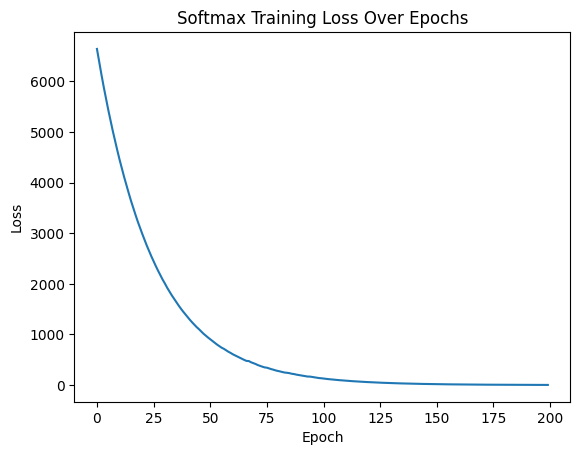

Training SVM...
SVM - Epoch 1/200, Loss: 18090.293500820342
SVM - Epoch 2/200, Loss: 8042.733236619199
SVM - Epoch 3/200, Loss: 7088.319177843345
SVM - Epoch 4/200, Loss: 6526.972574474348
SVM - Epoch 5/200, Loss: 6084.731686495386
SVM - Epoch 6/200, Loss: 5798.273192281728
SVM - Epoch 7/200, Loss: 5402.659243232879
SVM - Epoch 8/200, Loss: 5161.005879045934
SVM - Epoch 9/200, Loss: 4946.845297446315
SVM - Epoch 10/200, Loss: 4738.036686006213
SVM - Epoch 11/200, Loss: 4563.089753768037
SVM - Epoch 12/200, Loss: 4364.803826265929
SVM - Epoch 13/200, Loss: 4194.114581127428
SVM - Epoch 14/200, Loss: 4026.8386461468135
SVM - Epoch 15/200, Loss: 3869.7249810080575
SVM - Epoch 16/200, Loss: 3713.928622781093
SVM - Epoch 17/200, Loss: 3567.852490855369
SVM - Epoch 18/200, Loss: 3427.3502453192377
SVM - Epoch 19/200, Loss: 3292.7808415985405
SVM - Epoch 20/200, Loss: 3163.906132286831
SVM - Epoch 21/200, Loss: 3042.501431229042
SVM - Epoch 22/200, Loss: 2919.9475882548677
SVM - Epoch 23/200,

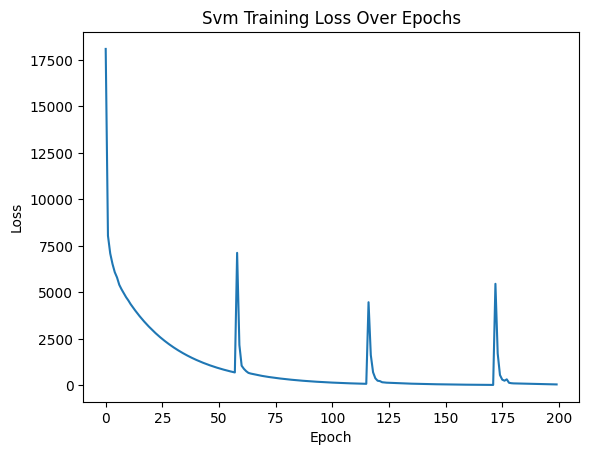

Softmax Regression Accuracy (Fold 4): 0.21678321678321677
SVM Accuracy (Fold 4): 0.2097902097902098
Fold 5/5
Training Softmax Regression...
Softmax - Epoch 1/200, Loss: 6622.231290074975
Softmax - Epoch 2/200, Loss: 6362.54957294661
Softmax - Epoch 3/200, Loss: 6112.544096068811
Softmax - Epoch 4/200, Loss: 5873.117985820371
Softmax - Epoch 5/200, Loss: 5643.823418940414
Softmax - Epoch 6/200, Loss: 5422.216122095885
Softmax - Epoch 7/200, Loss: 5210.26619299909
Softmax - Epoch 8/200, Loss: 5005.378222619439
Softmax - Epoch 9/200, Loss: 4812.554544552964
Softmax - Epoch 10/200, Loss: 4620.723227191673
Softmax - Epoch 11/200, Loss: 4440.735541376743
Softmax - Epoch 12/200, Loss: 4265.898520762062
Softmax - Epoch 13/200, Loss: 4101.680469462511
Softmax - Epoch 14/200, Loss: 3936.9472238369376
Softmax - Epoch 15/200, Loss: 3785.3968016996373
Softmax - Epoch 16/200, Loss: 3639.8487008442194
Softmax - Epoch 17/200, Loss: 3496.1728809564183
Softmax - Epoch 18/200, Loss: 3356.8145493171032
So

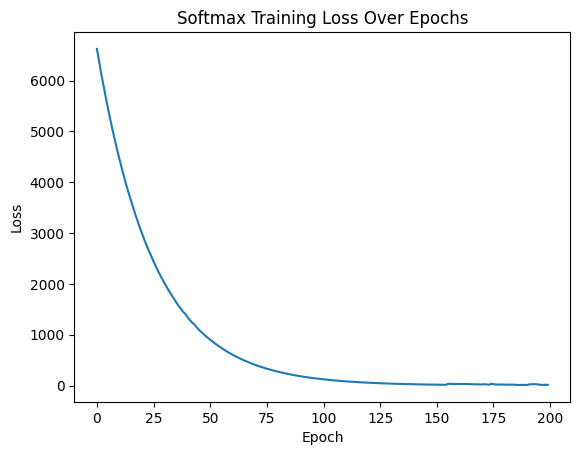

Training SVM...
SVM - Epoch 1/200, Loss: 16255.070726517397
SVM - Epoch 2/200, Loss: 8001.757270448347
SVM - Epoch 3/200, Loss: 7203.503699873312
SVM - Epoch 4/200, Loss: 6460.6216022343215
SVM - Epoch 5/200, Loss: 5912.401435591765
SVM - Epoch 6/200, Loss: 5944.585161825595
SVM - Epoch 7/200, Loss: 5531.440875795849
SVM - Epoch 8/200, Loss: 5308.568142426475
SVM - Epoch 9/200, Loss: 5019.8773417792145
SVM - Epoch 10/200, Loss: 4735.357133615308
SVM - Epoch 11/200, Loss: 4557.081998050481
SVM - Epoch 12/200, Loss: 4364.034303357509
SVM - Epoch 13/200, Loss: 4190.897043747259
SVM - Epoch 14/200, Loss: 4030.616267905283
SVM - Epoch 15/200, Loss: 3862.704890586802
SVM - Epoch 16/200, Loss: 3711.4626532332823
SVM - Epoch 17/200, Loss: 3561.4188475441165
SVM - Epoch 18/200, Loss: 3429.0002891982313
SVM - Epoch 19/200, Loss: 3293.419745993397
SVM - Epoch 20/200, Loss: 3158.5466486769787
SVM - Epoch 21/200, Loss: 3035.215525850879
SVM - Epoch 22/200, Loss: 2915.323033047391
SVM - Epoch 23/200

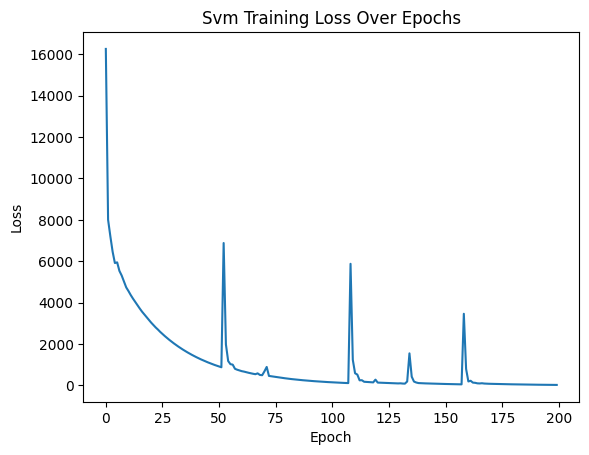

Softmax Regression Accuracy (Fold 5): 0.2014388489208633
SVM Accuracy (Fold 5): 0.2446043165467626
Average Softmax Regression Accuracy: 0.157100918346819
Average SVM Accuracy: 0.21412679665691098
The best algorithm is: SVM
Softmax Regression Test Accuracy: 0.75
SVM Test Accuracy: 0.8194444444444444


In [23]:
softmax_accuracies = []
svm_accuracies = []
num_epochs = 200

for fold in range(num_folds):
    print(f'Fold {fold + 1}/{num_folds}')
    X_train, y_train, X_val, y_val = split_data(images, labels, pairs, fold)
    
    # Initialize weights for Softmax Regression and SVM
    num_features = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    W_softmax = np.random.randn(num_features, num_classes)
    W_svm = np.random.randn(num_features, num_classes)
    
    # Train Softmax Regression
    print('Training Softmax Regression...')
    W_softmax, _ = softmax_gradient_descent(X_train, y_train, W_softmax, learning_rate, reg_strength, num_epochs, batch_size=32)
    
    # Train SVM
    print('Training SVM...')
    W_svm, _ = svm_gradient_descent(X_train, y_train, W_svm, learning_rate, reg_strength, num_epochs, batch_size=32)
    
    # Evaluate accuracy on the validation set
    softmax_accuracy = evaluate_accuracy(X_val, y_val, W_softmax)
    svm_accuracy = evaluate_accuracy(X_val, y_val, W_svm)
    
    softmax_accuracies.append(softmax_accuracy)
    svm_accuracies.append(svm_accuracy)
    print(f'Softmax Regression Accuracy (Fold {fold + 1}): {softmax_accuracy}')
    print(f'SVM Accuracy (Fold {fold + 1}): {svm_accuracy}')

# Calculate and print the average accuracy for each algorithm
avg_softmax_accuracy = np.mean(softmax_accuracies)
avg_svm_accuracy = np.mean(svm_accuracies)
print(f'Average Softmax Regression Accuracy: {avg_softmax_accuracy}')
print(f'Average SVM Accuracy: {avg_svm_accuracy}')

# Determine which algorithm shows the best accuracy
best_algorithm = 'Softmax Regression' if avg_softmax_accuracy > avg_svm_accuracy else 'SVM'
print(f'The best algorithm is: {best_algorithm}')

# Now, let's evaluate algorithms on the test set
softmax_test_accuracy = evaluate_accuracy(Xte, Yte, W_softmax)
print(f'Softmax Regression Test Accuracy: {softmax_test_accuracy}')
svm_test_accuracy = evaluate_accuracy(Xte, Yte, W_svm)
print(f'SVM Test Accuracy: {svm_test_accuracy}')

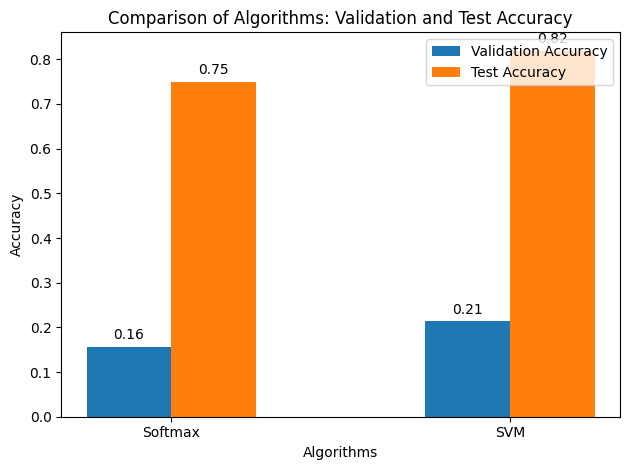

In [24]:
# Algorithm labels
plt_labels = ['Softmax', 'SVM']

# Validation accuracy values
validation_accuracies = [avg_softmax_accuracy, avg_svm_accuracy]

# Test accuracy values
test_accuracies = [softmax_test_accuracy, svm_test_accuracy]

# Bar width
width = 0.25

# X-axis positions for bars
x = np.arange(len(plt_labels))

# Create a figure and axis for the bar chart
fig, ax = plt.subplots()

# Bar chart for validation accuracies
rects1 = ax.bar(x - width/2, validation_accuracies, width, label='Validation Accuracy')

# Bar chart for test accuracies
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Set labels, title, and legend
ax.set_xlabel('Algorithms')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Algorithms: Validation and Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(plt_labels)
ax.legend()

# Add values on top of the bars
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Add values for both validation and test accuracies
add_values(rects1)
add_values(rects2)

# Show the bar chart
plt.tight_layout()
plt.show()

In [29]:
def reshape(image):
    image = image.reshape((image_size, image_size, 3))
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

def softmax_make_prediction(index):
    # Make a prediction using Softmax Regression
    image = images[index]
    scores = np.dot(image, W_softmax)
    predicted_class = np.argmax(scores)
    reshape(image)
    # Map the predicted class index back to class label
    predicted_label = class_labels[predicted_class]

    # Print the predicted label
    print(f'Predicted: {predicted_label}')
    print(f'Label: {list(label_mapping.keys())[list(label_mapping.values()).index(labels[index])]}')

def svm_make_prediction(index):
    image = images[index]
    scores = np.dot(image, W_svm)
    predicted_class = np.argmax(scores)
    reshape(image)
    # Map the predicted class index back to class label
    predicted_label = class_labels[predicted_class]
    
    # Print the predicted label
    print(f'Predicted: {predicted_label}')
    print(f'Label: {list(label_mapping.keys())[list(label_mapping.values()).index(labels[index])]}')


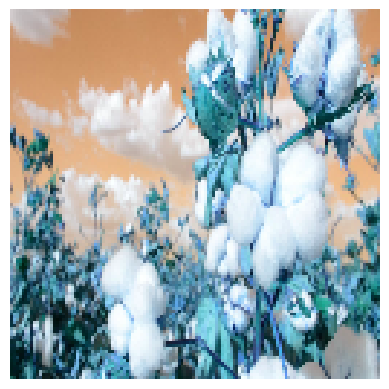

Predicted: cotton
Label: cotton


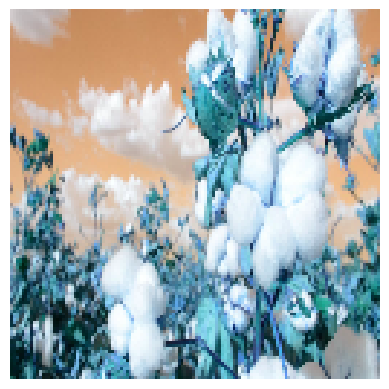

Predicted: cotton
Label: cotton


In [38]:
index = 234
softmax_make_prediction(index)
svm_make_prediction(index)